In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MaxNLocator
from matplotlib.legend_handler import HandlerLine2D
from matplotlib import patches
from math import atan2,degrees


<h3>Definiciones:</h3>

In [9]:
def bound(value, low=-90, high=90):
    diff = high - low
    return (((value - low) % diff) + low)

def get_cluster_color(cluster, list_of_colors):
    return list_of_colors[cluster]

line_vectors = []
bisector_vectors = []

def get_cluster_separator_points(i, j, min_nodes, max_nodes, depot_x, depot_y):
    x_1 = min_nodes[i][0]
    y_1 = min_nodes[i][1]
    x_2 = max_nodes[j][0]
    y_2 = max_nodes[j][1]    
    mid_x = (x_1 + x_2)/2
    mid_y = (y_1 + y_2)/2
    pto1 = [depot_x, depot_y]
    pto2 = [mid_x, mid_y]
    
    V = [pto2[0] - pto1[0], pto2[1] - pto1[1]]
    factor_distance = math.sqrt((depot_x - x_2)**2 + (depot_y - y_2)**2)
    pext = [pto1[0] + V[0]*factor_distance, pto1[1] + V[1]*factor_distance]
    line_vectors.append(pto2)
        
    return [pto1 , pext]

def calculate_bisector(i, j, line_vectors):
    V_a = line_vectors[i]
    V_b = line_vectors[j]
    bisector = [(V_a[0]+V_b[0])/2, (V_a[1]+V_b[1])/2]
    return bisector

def get_ellipse_coords(a=0.0, b=0.0, x=0.0, y=0.0, angle=0.0, k=1):
    pts = np.zeros((360*k+1, 2))

    beta = -angle * np.pi/180.0
    sin_beta = np.sin(beta)
    cos_beta = np.cos(beta)
    alpha = np.radians(np.r_[0.:360.:1j*(360*k+1)])

    sin_alpha = np.sin(alpha)
    cos_alpha = np.cos(alpha)

    pts[:, 0] = x + (a * cos_alpha * cos_beta - b * sin_alpha * sin_beta)
    pts[:, 1] = y + (a * cos_alpha * sin_beta + b * sin_alpha * cos_beta)

    return pts

    
def GetAngleOfLineBetweenTwoPoints(p1, p2):
    xDiff = p2[0] - p1[0]
    yDiff = p2[1] - p1[1]
    return degrees(atan2(yDiff, xDiff))

def midpoint(p1, p2):
    return [(p1[0] + p2[0])/2, (p1[1] + p2[1])/2]

def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

######################################################################

def plot_instancia(archivo, xlim=[0,200], ylim=[0,200]):
    df_instancia = pd.read_csv(archivo)
    
    cant_nodes = df_instancia.shape[0]

    palette = []
    for i in range (cant_nodes - 1):
        palette.append('#000000')

    palette.insert(0, '#ff00ff')

    
    a4_dims = (10.75, 3.975)
    sns.set_style("whitegrid")

    ax = sns.lmplot(x='x', y='y', data=df_instancia,
        fit_reg=False,
        hue='id',
        palette=palette,
        legend=False)
    
    leyendas = ["depósito", "clientes"]

    plt.legend(leyendas, loc='center left', bbox_to_anchor=(1.0, 0.5), shadow=True)

    min_point_x = df_instancia['x'].min()
    min_point_y = df_instancia['y'].min()
    max_point_x = df_instancia['x'].max()
    max_point_y = df_instancia['y'].max()

    if abs(max_point_x - min_point_x) > abs(max_point_y - min_point_y):
        max_cota = [min_point_x, max_point_x]
    else:
        max_cota = [min_point_y, max_point_y]


    plt.xlabel("x", fontsize=16)
    plt.ylabel("y", fontsize=16)

    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

    plt.tick_params(labelsize=10, rotation=30)

    plt.show()

######################################################################

def plot_clusters_sweep(archivo, palette = 'cubehelix', show_separation_lines = True, padding = 20, xlim=[0,200], ylim=[0,200], fix_last_line=True):
    df_clusters = pd.read_csv(archivo)
    
    cant_clusters = df_clusters['cluster'].max()
    cluster_colors = sns.color_palette(palette, cant_clusters).as_hex()
    cluster_colors.insert(0, '#000000')


    ax = sns.lmplot(x='x', y='y', data=df_clusters,
        fit_reg=False,
        hue='cluster',
        palette=cluster_colors,
        legend=False)

    leyendas = ["depósito"]
    for i in range(0, cant_clusters):
        leyendas.append("clúster " + str(i + 1))

    plt.legend(leyendas, loc='center left', bbox_to_anchor=(1.0, 0.5), shadow=True)


    if show_separation_lines:
        # Calculate and draw cluster separation lines
        depot_x = int(df_clusters.loc[df_clusters['cluster'] == 0].x)
        depot_y = int(df_clusters.loc[df_clusters['cluster'] == 0].y)

        min_nodes = []
        max_nodes = []
        for i in range(1, cant_clusters+1):
            filtered_nodes = df_clusters.loc[df_clusters['cluster'] == i]
            min_node_from_cluster = filtered_nodes.loc[filtered_nodes['theta'].idxmin()]
            max_node_from_cluster = filtered_nodes.loc[filtered_nodes['theta'].idxmax()]

            min_x = min_node_from_cluster.x
            min_y = min_node_from_cluster.y
            min_nodes.append((min_x,min_y))
            max_x = max_node_from_cluster.x
            max_y = max_node_from_cluster.y
            max_nodes.append((max_x,max_y))

        for i in range(0, cant_clusters-1):
            puntos = get_cluster_separator_points(i, i+1, min_nodes, max_nodes, depot_x, depot_y)
            plt.plot([puntos[0][0], puntos[1][0]], [puntos[0][1], puntos[1][1]], 'k--', linewidth=1, alpha=0.5)
        puntos = get_cluster_separator_points(cant_clusters-1, 0, min_nodes, max_nodes, depot_x, depot_y)
        plt.plot([puntos[0][0], puntos[1][0] + (2*(puntos[0][0]) if fix_last_line else 0)], [puntos[0][1], puntos[1][1] + (2*(puntos[0][1]) if fix_last_line else 0)], 'k--', linewidth=1, alpha=0.5)

        # Draw bisection points
        for i in range(0, len(line_vectors)-1):
            bisector = calculate_bisector(i, i+1, line_vectors)
            bisector_vectors.append(bisector)
            #plt.plot([depot_x, bisector_vectors[i][0]], [depot_y, bisector_vectors[i][1]], 'r--', linewidth=1)
        #    plt.annotate(leyendas[i+2],
        #                bisector,
        #                horizontalalignment='center',
        #                verticalalignment='center',
        #                size=24, alpha=0.5, weight= 'bold',
        #                #rotation=bound(math.degrees(math.atan2(bisector[1] - depot_y, bisector[0] - depot_x))),
        #                color=cluster_colors[i+2])

        bisector = calculate_bisector(len(line_vectors)-1, 0, line_vectors)
        bisector_vectors.append(bisector)
        #plt.plot([depot_x, bisector_vectors[len(line_vectors)-1][0]], [depot_y, bisector_vectors[len(line_vectors)-1][1]], 'r--', linewidth=1)
        #plt.annotate(leyendas[1],
        #                bisector,
        #                horizontalalignment='center',
        #                verticalalignment='center',
        #                size=24, alpha=0.5, weight= 'bold',
        #                #rotation=bound(math.degrees(math.atan2(bisector[1] - depot_y, bisector[0] - depot_x))),
        #                color=cluster_colors[1])


    min_point_x = df_clusters['x'].min()
    min_point_y = df_clusters['y'].min()
    max_point_x = df_clusters['x'].max()
    max_point_y = df_clusters['y'].max()

    if abs(max_point_x - min_point_x) > abs(max_point_y - min_point_y):
        max_cota = [min_point_x, max_point_x]
    else:
        max_cota = [min_point_y, max_point_y]

    plt.xlabel("x", fontsize=16)
    plt.ylabel("y", fontsize=16)

    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

    plt.tick_params(labelsize=10, rotation=30)

    plt.show()
    

    
def plot_clusters(archivo, palette = 'cubehelix', show_labels = True, columnas=1, padding = 20, xlim=[0,200], ylim=[0,200]):
    df_clusters = pd.read_csv(archivo)
    
    cant_clusters = df_clusters['cluster'].max()
    cluster_colors = sns.color_palette(palette, cant_clusters).as_hex()
    cluster_colors.insert(0, '#000000')


    ax = sns.lmplot(x='x', y='y', data=df_clusters,
        fit_reg=False,
        hue='cluster',
        palette=cluster_colors,
        legend=False)

    leyendas = ["depósito"]
    for i in range(0, cant_clusters):
        leyendas.append("clúster " + str(i + 1))

    plt.legend(leyendas, loc='center left', bbox_to_anchor=(1.0, 0.5), shadow=True, ncol=columnas)
    
    if show_labels:
        for cluster in range(1, cant_clusters + 1):
            plt.annotate(str(cluster), df_clusters.loc[df_clusters['cluster']==cluster,['x','y']].mean(),
                        horizontalalignment='center',
                        verticalalignment='center',
                        size=12,
                        weight='bold',
                        color='black',
                        backgroundcolor=cluster_colors[cluster] + '40')

    min_point_x = df_clusters['x'].min()
    min_point_y = df_clusters['y'].min()
    max_point_x = df_clusters['x'].max()
    max_point_y = df_clusters['y'].max()

    if abs(max_point_x - min_point_x) > abs(max_point_y - min_point_y):
        max_cota = [min_point_x, max_point_x]
    else:
        max_cota = [min_point_y, max_point_y]

    plt.xlabel("x", fontsize=16)
    plt.ylabel("y", fontsize=16)

    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

    plt.tick_params(labelsize=10, rotation=30)

    plt.show()
    

    
    
    
def plot_rutas(archivo_instancia, archivo_rutas, palette='Set1', padding=20, xlim=[0,200], ylim=[0,200]):
    df_rutas = pd.read_csv(archivo_rutas)
    df_instancia = pd.read_csv(archivo_instancia)
    
    for index, row in df_rutas.iterrows():
        camion = row['camion']
        for nodo in row['ruta'].split():
            df_instancia.set_value(int(nodo)-1, 'camion', int(camion))

    # El nodo deposito no tiene "camion"
    df_instancia.set_value(0, 'camion', 0)
        
    cant_camiones = df_rutas['camion'].max()
    routes_colors = sns.color_palette(palette, cant_camiones).as_hex()
    routes_colors.insert(0, '#000000')

    a4_dims = (10.75, 3.975)
    sns.set_style("whitegrid")
    
    df_ = pd.DataFrame(columns=['x', 'y'])

    ax = sns.lmplot(x='x', y='y', data=df_,
        fit_reg=False,
        legend=False)
    
    leyendas = ["depósito"]
    for i in range(0, cant_camiones):
        leyendas.append("ruta " + str(i + 1))

    #plt.legend(leyendas, loc='center left', bbox_to_anchor=(1.0, 0.5), shadow=True)

    for k in range(1, cant_camiones+1):
        nodos_ruta = df_rutas.iloc[k-1]['ruta'].split()
        for i in range(0, len(nodos_ruta) - 1):
            nodo_a_info = df_instancia.loc[df_instancia['id'] == int(nodos_ruta[i])]
            nodo_b_info = df_instancia.loc[df_instancia['id'] == int(nodos_ruta[i+1])]
            nodo_a_x = float(nodo_a_info['x'])
            nodo_a_y = float(nodo_a_info['y'])
            nodo_b_x = float(nodo_b_info['x'])
            nodo_b_y = float(nodo_b_info['y'])
            path_color = routes_colors[k]
            
            plt.plot([nodo_a_x, nodo_b_x], [nodo_a_y, nodo_b_y], '-', marker='o', label="Ruta " + str(k) if i == 0 else '', color=path_color, linewidth=2)
                
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), shadow=True)

    depot_x = int(df_instancia.loc[df_instancia['id'] == 1].x)
    depot_y = int(df_instancia.loc[df_instancia['id'] == 1].y)
    
    plt.plot([depot_x, depot_x], [depot_y, depot_y], '-', marker='o', color='#000000', linewidth=20)
    
    min_point_x = df_instancia['x'].min()
    min_point_y = df_instancia['y'].min()
    max_point_x = df_instancia['x'].max()
    max_point_y = df_instancia['y'].max()

    if abs(max_point_x - min_point_x) > abs(max_point_y - min_point_y):
        max_cota = [min_point_x, max_point_x]
    else:
        max_cota = [min_point_y, max_point_y]
    
    plt.xlabel("x", fontsize=16)
    plt.ylabel("y", fontsize=16)

    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

    plt.tick_params(labelsize=10, rotation=30)

    plt.show()
    
    

    
def plot_solucion_inicial_savings(archivo_instancia, palette='Set1', columnas=2, padding=20, xlim=[0,200], ylim=[0,200]):
    df_instancia = pd.read_csv(archivo_instancia)
    
    # Inicialmente hay n-1 camiones
    cant_camiones = df_instancia['id'].max() - 1
    
    colores_camiones = sns.color_palette(palette, cant_camiones).as_hex()
    colores_camiones.insert(0, '#000000')

    ax = sns.lmplot(x='x', y='y', data=df_instancia,
        fit_reg=False,
        hue='id',
        palette=colores_camiones,
        legend=False)
    
    
    depot = df_instancia.loc[df_instancia['id'] == 1]
    depot_x = float(depot['x'])
    depot_y = float(depot['y'])
    
    legends = []
    
    for i in range(2, cant_camiones + 2):
        client = df_instancia.loc[df_instancia['id'] == i]
        client_x = float(client['x'])
        client_y = float(client['y'])
        
        midpoint_from_depot = midpoint([depot_x, depot_y], [client_x, client_y])
        distance_from_depot = distance([depot_x, depot_y], [client_x, client_y])
        angle = GetAngleOfLineBetweenTwoPoints([depot_x, depot_y], [client_x, client_y])
        
        ellip = get_ellipse_coords(a=1, b=distance_from_depot/2, x=midpoint_from_depot[0], y=midpoint_from_depot[1], angle=90-angle, k=2)
        plt.plot(ellip[:,0], ellip[:, 1], lw=1, linestyle='--', color=colores_camiones[i-1], linewidth=1)
        legends.append("Ruta inicial " + str(i-1))
        
    plt.legend(legends, loc='center left', bbox_to_anchor=(1.0, 0.5), shadow=True, ncol=columnas)
    
    
    min_point_x = df_instancia['x'].min()
    min_point_y = df_instancia['y'].min()
    max_point_x = df_instancia['x'].max()
    max_point_y = df_instancia['y'].max()

    if abs(max_point_x - min_point_x) > abs(max_point_y - min_point_y):
        max_cota = [min_point_x, max_point_x]
    else:
        max_cota = [min_point_y, max_point_y]
    
    plt.xlabel("x", fontsize=16)
    plt.ylabel("y", fontsize=16)

    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])

    plt.tick_params(labelsize=10, rotation=30)

    plt.show()
        

<h3>Instancia normal:</h3>

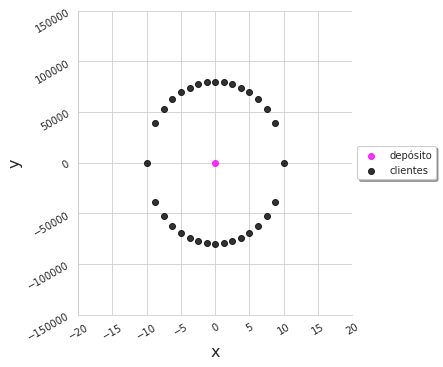

In [11]:
plot_instancia('../test/1-savings/ELIPSE/tabla0.csv', xlim=[-20,20], ylim=[-150000,150000])

<h3>Clústers que se formaron (Sweep algorithm):</h3>

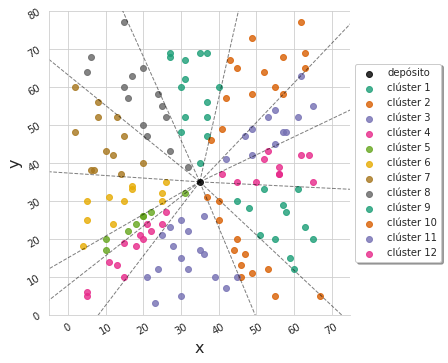

In [76]:
plot_clusters_sweep('../output/3-sweep-algorithm/clusters.csv', palette='Dark2', show_separation_lines=True, xlim=[-5,75], ylim=[0,80], fix_last_line=False)

<h3>Clústers que se formaron (clusterización del TP2):</h3>

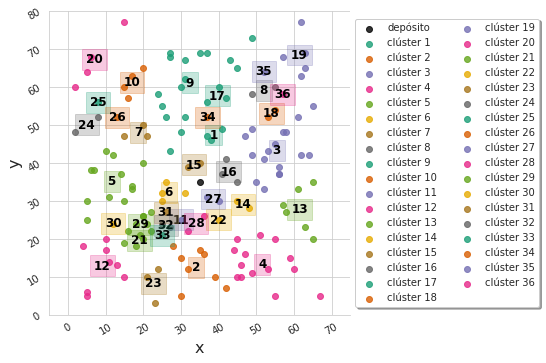

In [64]:
plot_clusters('../output/4-otra-clusterizacion/clusters.csv', palette='Dark2', show_labels=True, columnas= 2, xlim=[-5,75], ylim=[0,80])

<h3>Rutas de los camiones:</h3>

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:266: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:269: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


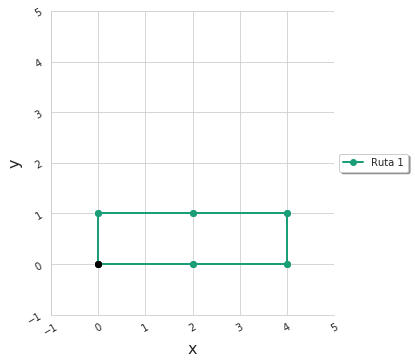

In [84]:
plot_rutas('../output/test.csv', '../output/rutaOptima.csv', palette='Dark2', xlim=[-1,5], ylim=[-1,5])
#plot_rutas('../output/4-otra-clusterizacion/clusters.csv', '../output/4-otra-clusterizacion/rutas.csv', palette='Set1', xlim=[0,100], ylim=[0,100])

<h3>Rutas inicial de los camiones en savings:</h3>

In [ ]:
#plot_solucion_inicial_savings('../output/3-sweep-algorithm/clusters.csv', palette='Set1', columnas=5, xlim=[0,200], ylim=[0,200])
plot_solucion_inicial_savings('../output/4-otra-clusterizacion/clusters.csv', palette='Set1', columnas=2, xlim=[0,100], ylim=[0,100])